### Reguralization (dropout, normalization)

1. library
2. load dataset and preprocess
3. MLP naive setting
4. MLP batch norm (with test phase/ with train,test phase)
5. dropout
6. batch norm & dropout

In [1]:
##library

import os
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.datasets import mnist as data
try: os.mkdir('MNIST')
except: pass

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
##load dataset and preprocess

#load dataset
(x_train, y_train), (x_test, y_test) = data.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, '\n')

train_n_sample = len(x_train)
shape = x_train[0].shape[0:]
n_class = len(np.unique(y_train))
print(train_n_sample, shape, n_class, '\n')

#x reshape and x normalization
X_train = x_train.reshape(-1, np.prod(shape)) / 255.
X_test = x_test.reshape(-1, np.prod(shape)) / 255.

#y onehot
Y_train = np.eye(n_class)[y_train.reshape(-1)]
Y_test = np.eye(n_class)[y_test.reshape(-1)]

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

60000 (28, 28) 10 

(60000, 784) (10000, 784) (60000, 10) (10000, 10)


In [10]:
##multi-layer perceptron (MLP)

#hyper-parameter setting
training_epochs = 100
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
activation = tf.nn.tanh

In [13]:
##build FC layer model

#build 3-layer fully-connected neural network model
#hidden layers' size is [1024, 300]
tf.reset_default_graph()

#placeholder
tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

#model
hidden1 = tf.layers.dense(tf_X, 512, activation=activation)
logit = tf.layers.dense(hidden1, n_class)
pred = tf.nn.softmax(logit)

#loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [15]:
##train model

with tf.Session() as sess:
    #init
    sess.run(tf.global_variables_initializer())
    
    #train
    epoch_losses, iter_losses = [],[]
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            #get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss],
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
            
    #result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train})
    test_pred = sess.run(pred, feed_dict={tf_X:X_test})
    
    #save
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/naive_512/model')

Epoch: 10, 	 Loss: 0.11329735070466995
Epoch: 20, 	 Loss: 0.05622197315096855
Epoch: 30, 	 Loss: 0.03304554149508476
Epoch: 40, 	 Loss: 0.020751362666487694
Epoch: 50, 	 Loss: 0.01375524327158928
Epoch: 60, 	 Loss: 0.009726607240736485
Epoch: 70, 	 Loss: 0.007215866819024086
Epoch: 80, 	 Loss: 0.005555033218115568
Epoch: 90, 	 Loss: 0.0044400738552212715
Epoch: 100, 	 Loss: 0.0036810142919421196


In [19]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/naive_512/model.meta')
    saver.restore(sess, 'MNIST/naive_512/model')

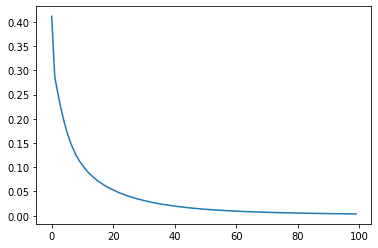

train  accuracy:  0.9999833333333333
test  accuracy:  0.9809
[[ 971    0    1    0    1    1    2    1    3    0]
 [   0 1125    2    2    0    1    2    1    2    0]
 [   4    0 1013    1    1    0    4    5    4    0]
 [   0    0    4  991    0    3    0    4    3    5]
 [   2    0    1    1  961    0    5    2    1    9]
 [   4    0    0    6    1  870    4    1    4    2]
 [   6    3    0    1    2    4  940    0    2    0]
 [   2    3    6    3    1    0    0 1005    4    4]
 [   3    0    2    4    3    3    3    2  952    2]
 [   2    2    0    6    6    1    1    6    4  981]]


In [20]:
##plot result

#plot epoch losses
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
plot_epoch_losses(epoch_losses)

#accuracy
def print_accuracy(label, pred, name=''):
    accuracy = np.mean(label==pred)
    print(name, ' accuracy: ', accuracy)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')

#confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

In [22]:
##build FC layer model

# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

#placeholder
tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

# model
hidden1 = tf.layers.dense(tf_X, hidden_nodes[0], activation=activation)
hidden2 = tf.layers.dense(hidden1, hidden_nodes[1], activation=activation)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, pred) ####
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [24]:
##train & save model

with tf.Session() as sess:
    #init
    sess.run(tf.global_variables_initializer())
    
    #train
    epoch_losses, iter_losses = [], []
    total_batch = int(train_n_sample / batch_size)
    for epoch in range(training_epochs):
        #shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            #get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/naive_1024-300/model')

Epoch: 10, 	 Loss: 1.5215450525283813
Epoch: 20, 	 Loss: 1.502105474472046
Epoch: 30, 	 Loss: 1.4921897649765015
Epoch: 40, 	 Loss: 1.4859610795974731
Epoch: 50, 	 Loss: 1.4815737009048462
Epoch: 60, 	 Loss: 1.4786770343780518
Epoch: 70, 	 Loss: 1.4766343832015991
Epoch: 80, 	 Loss: 1.4750287532806396
Epoch: 90, 	 Loss: 1.4737857580184937
Epoch: 100, 	 Loss: 1.4728362560272217


In [26]:
##load model

with tf.Session() as sess:
    sess = tf.Session()
    saver = tf.train.import_meta_graph('MNIST/naive_1024-300/model.meta')
    saver.restore(sess, 'MNIST/naive_1024-300/model')
    saver.save(sess, 'MNIST/naive_1024-300/model')

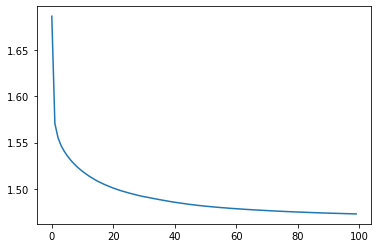

train  accuracy:  0.9899333333333333
test  accuracy:  0.9761
[[ 970    0    2    2    0    2    2    1    1    0]
 [   0 1122    3    2    0    1    3    2    2    0]
 [   7    2  998    6    3    1    3    5    7    0]
 [   0    0    3  984    0    7    1    8    3    4]
 [   1    0    4    0  962    1    4    3    1    6]
 [   3    1    0    4    1  872    6    1    2    2]
 [   7    1    0    1    2    7  935    1    4    0]
 [   0    5   11    4    0    1    0  999    4    4]
 [   5    1    2    2    3    5    1    5  947    3]
 [   4    3    0    6   10    3    1    8    2  972]]


In [27]:
##plot result

# plot epoch losses
def plot_epoch_losses(epoch_losses):
    plt.figure()
    plt.plot(epoch_losses)
    plt.show()
plot_epoch_losses(epoch_losses)

# accuracy
def print_accuracy(label, pred, name):
    accuracy = np.mean(label==pred)
    print(name, ' accuracy: ', accuracy)
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')

# confusion matrix
def print_confusion_matrix(label, pred):
    matrix = confusion_matrix(label, pred)
    print(matrix)
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

In [28]:
##build FC layer model (show inner distribution)

#build 3-layer fully-connected neural network model
#hidden layers' size is [1024, 300]
tf.reset_default_graph()

#placeholder
tf_X = tf.placeholder(tf.float32, (None, np.prod(shape)))
tf_Y = tf.placeholder(tf.float32, (None, n_class))

#model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
hidden1 = activation(output1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
hidden2 = activation(output2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [29]:
##train & save model

with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/naive_1024-300/model')

Epoch: 10, 	 Loss: 0.05921902880072594
Epoch: 20, 	 Loss: 0.02240726165473461
Epoch: 30, 	 Loss: 0.009842796251177788
Epoch: 40, 	 Loss: 0.005242470186203718
Epoch: 50, 	 Loss: 0.0033150508534163237
Epoch: 60, 	 Loss: 0.0023723002523183823
Epoch: 70, 	 Loss: 0.0018244500970467925
Epoch: 80, 	 Loss: 0.001470488146878779
Epoch: 90, 	 Loss: 0.0012159418547526002
Epoch: 100, 	 Loss: 0.0010376055724918842


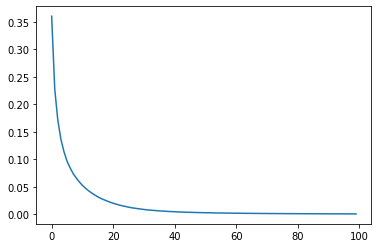

train  accuracy:  1.0
test  accuracy:  0.9823
[[ 974    0    1    1    1    1    0    1    1    0]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   4    0 1011    2    2    0    3    5    5    0]
 [   0    0    3  992    0    4    0    3    2    6]
 [   0    0    4    0  964    0    3    2    0    9]
 [   2    0    0    6    1  875    4    0    3    1]
 [   3    2    1    1    3    4  942    0    2    0]
 [   1    2    5    4    1    0    0 1007    3    5]
 [   3    0    3    5    2    3    2    3  949    4]
 [   1    2    0    5    9    2    0    5    2  983]]


In [30]:
##plot result

#plot epoch losses
plot_epoch_losses(epoch_losses)
#accuracy
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')
#confusion matrix
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


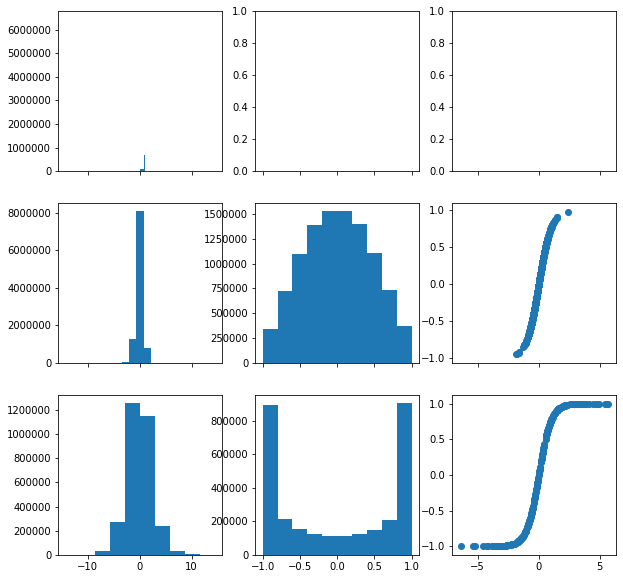

In [31]:
##show inner distribution

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/naive_1024-300/model.meta')
    saver.restore(sess, 'MNIST/naive_1024-300/model')

    [x, o1, h1, o2, h2] = sess.run(
        [tf_X, output1, hidden1, output2, hidden2], 
        feed_dict={tf_X: X_test})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex='col')
    axs[0, 0].hist(x.reshape(-1))
    axs[1, 0].hist(o1.reshape(-1))
    axs[1, 1].hist(h1.reshape(-1))
    axs[1, 2].scatter(o1[0], h1[0])
    axs[2, 0].hist(o2.reshape(-1))
    axs[2, 1].hist(h2.reshape(-1))
    axs[2, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x, o1, h1, o2, h2)

In [33]:
##add batch normalize layers

#build 3-layer fully connected neural neural network model
#hidden layers; size is [1024, 300]
tf.reset_default_graph()

#placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])

#model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1)
hidden1 = activation(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2)
hidden2 = activation(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

#loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [35]:
##train/test phase in batch_norm - only test

#build 3-layer fully-connected neural network model
#hidden layers' size is [1024, 300]
tf.reset_default_graph()

#placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])

#model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1, is_training=False)
hidden1 = activation(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2, is_training=False)
hidden2 = activation(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

#loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [36]:
##train model

with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm_off_1024-300/model')

Epoch: 10, 	 Loss: 0.058486733585596085
Epoch: 20, 	 Loss: 0.02153801918029785
Epoch: 30, 	 Loss: 0.009670386090874672
Epoch: 40, 	 Loss: 0.005258932709693909
Epoch: 50, 	 Loss: 0.003362413262948394
Epoch: 60, 	 Loss: 0.0024031945504248142
Epoch: 70, 	 Loss: 0.0018473784439265728
Epoch: 80, 	 Loss: 0.0014868311118334532
Epoch: 90, 	 Loss: 0.0012351711047813296
Epoch: 100, 	 Loss: 0.0010546259582042694


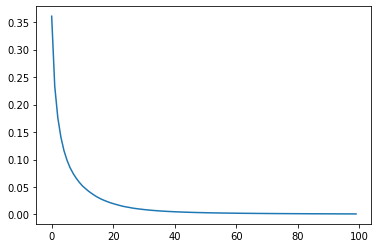

train  accuracy:  1.0
test  accuracy:  0.9815
[[ 972    0    2    0    1    1    1    1    1    1]
 [   0 1125    1    2    0    1    2    1    3    0]
 [   6    1 1009    2    2    0    3    3    5    1]
 [   0    0    4  990    0    6    0    2    4    4]
 [   1    0    1    1  963    0    4    2    1    9]
 [   3    0    0    7    1  869    4    1    3    4]
 [   4    2    1    1    2    5  942    0    1    0]
 [   2    2    9    1    1    0    0 1006    2    5]
 [   3    0    3    3    3    4    0    3  952    3]
 [   1    2    0    3   10    1    1    3    1  987]]


In [39]:
##plot result

#plot epoch losses
plot_epoch_losses(epoch_losses)
#accuracy
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1),'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')
#confusion matrix
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


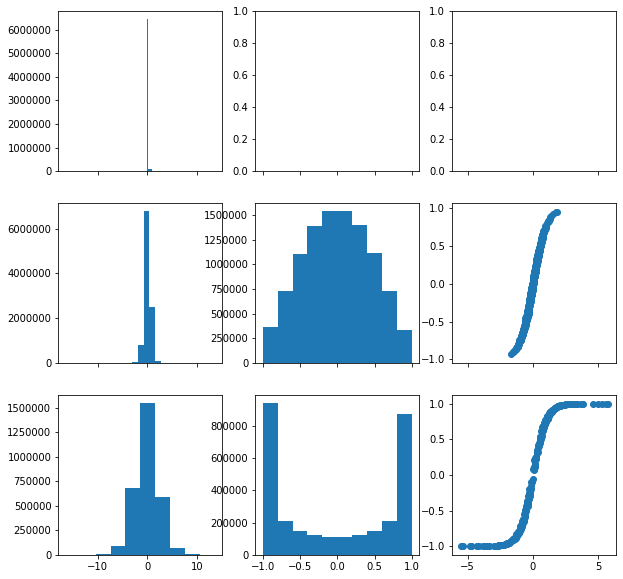

In [40]:
##show inner distribution

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/batch_norm_off_1024-300/model.meta')
    saver.restore(sess, 'MNIST/batch_norm_off_1024-300/model')

    [x, o1, h1, o2, h2] = sess.run(
        [tf_X, output1, hidden1, output2, hidden2], 
        feed_dict={tf_X: X_test})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)

plot_inner_dist(x, o1, h1, o2, h2)

In [41]:
##train/test phase in batch_norm - train&test

# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])
is_train = tf.placeholder(tf.bool, [])

# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1, is_training=is_train)
hidden1 = activation(norm1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2, is_training=is_train)
hidden2 = activation(norm2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [42]:
##train & save model

with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train, is_train:True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test, is_train:False})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm_1024-300/model')

Epoch: 10, 	 Loss: 0.014798385091125965
Epoch: 20, 	 Loss: 0.001701219705864787
Epoch: 30, 	 Loss: 0.0006969162495806813
Epoch: 40, 	 Loss: 0.0005432016914710402
Epoch: 50, 	 Loss: 0.0005825536209158599
Epoch: 60, 	 Loss: 0.00027505800244398415
Epoch: 70, 	 Loss: 0.00021557544823735952
Epoch: 80, 	 Loss: 0.00016010337276384234
Epoch: 90, 	 Loss: 0.00022438094310928136
Epoch: 100, 	 Loss: 0.0003413766098674387


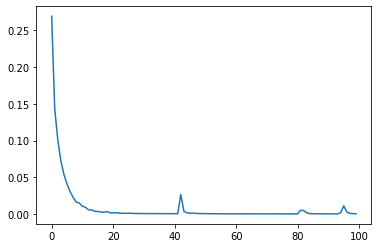

train  accuracy:  1.0
test  accuracy:  0.9824
[[ 973    1    1    0    1    1    1    1    1    0]
 [   0 1127    3    0    0    0    2    1    2    0]
 [   6    1 1008    1    3    0    3    4    5    1]
 [   0    0    3  995    0    3    0    4    3    2]
 [   1    0    0    1  968    0    4    0    1    7]
 [   1    0    0    8    0  871    5    2    3    2]
 [   3    2    1    0    3    3  944    0    2    0]
 [   0    5    7    2    1    0    0 1008    0    5]
 [   2    0    3    3    3    2    0    4  955    2]
 [   3    2    0    8    9    3    0    8    1  975]]


In [43]:
##plot result

#plot epoch losses
plot_epoch_losses(epoch_losses)
#accuracy
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')
#confusion matrix
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

(10000, 784) (10000, 1024) (10000, 1024) (10000, 300) (10000, 300)


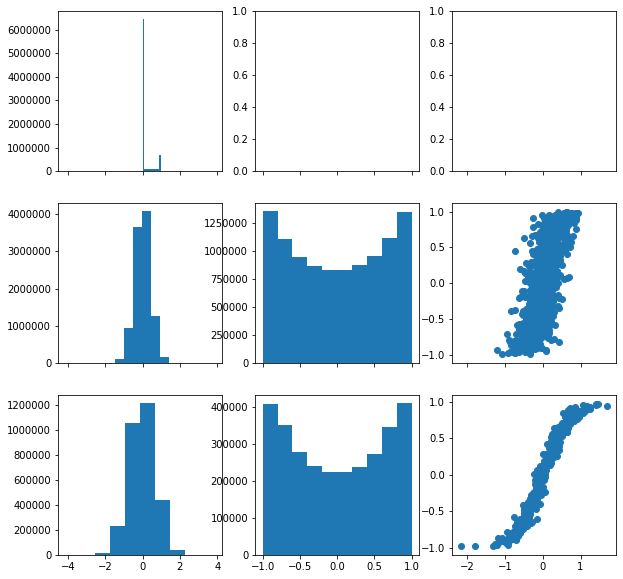

In [44]:
##show inner distribution

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('MNIST/batch_norm_1024-300/model.meta')
    saver.restore(sess, 'MNIST/batch_norm_1024-300/model')
    
    [x, o1, h1, o2, h2] = sess.run(
        [tf_X, output1, hidden1, output2, hidden2],
        feed_dict={tf_X: X_test, is_train:False})
    print(x.shape, o1.shape, h1.shape, o2.shape, h2.shape)
    
plot_inner_dist(x, o1, h1, o2, h2)

In [45]:
##add dropout layers

#hyper parameter setting
training_epochs = 200
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
activation = tf.nn.tanh
dropout_rate = .2

In [46]:
# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])
is_train = tf.placeholder(tf.bool, [])

# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
dropout1 = tf.contrib.layers.dropout(output1, keep_prob=1.-dropout_rate, is_training=is_train)
hidden1 = activation(dropout1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
dropout2 = tf.contrib.layers.dropout(output2, keep_prob=1.-dropout_rate, is_training=is_train)
hidden2 = activation(dropout2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [47]:
##train&save model

with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train, is_train:True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test, is_train:False})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/dropout_1024-300/model')

Epoch: 10, 	 Loss: 0.09031850099563599
Epoch: 20, 	 Loss: 0.05291939154267311
Epoch: 30, 	 Loss: 0.03542057052254677
Epoch: 40, 	 Loss: 0.02542729303240776
Epoch: 50, 	 Loss: 0.0200672410428524
Epoch: 60, 	 Loss: 0.015241335146129131
Epoch: 70, 	 Loss: 0.0128135085105896
Epoch: 80, 	 Loss: 0.010257720947265625
Epoch: 90, 	 Loss: 0.009977644309401512
Epoch: 100, 	 Loss: 0.007796685677021742
Epoch: 110, 	 Loss: 0.007196377031505108
Epoch: 120, 	 Loss: 0.0064133149571716785
Epoch: 130, 	 Loss: 0.005253570154309273
Epoch: 140, 	 Loss: 0.005449199583381414
Epoch: 150, 	 Loss: 0.004422921221703291
Epoch: 160, 	 Loss: 0.00450702290982008
Epoch: 170, 	 Loss: 0.004250641446560621
Epoch: 180, 	 Loss: 0.003058026311919093
Epoch: 190, 	 Loss: 0.0035438125487416983
Epoch: 200, 	 Loss: 0.00306367757730186


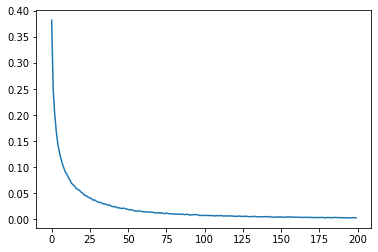

train  accuracy:  0.99995
test  accuracy:  0.9832
[[ 975    0    1    0    1    0    0    1    2    0]
 [   0 1123    2    2    0    1    2    1    4    0]
 [   6    1 1014    1    1    0    2    3    4    0]
 [   0    0    4  998    0    0    0    2    3    3]
 [   0    0    2    1  966    0    4    2    2    5]
 [   3    0    0   13    1  863    4    1    6    1]
 [   3    2    1    1    2    3  945    0    1    0]
 [   1    1    8    1    0    0    0 1011    4    2]
 [   2    0    1    2    1    0    0    2  964    2]
 [   3    2    0    7    8    2    0    5    9  973]]


In [48]:
##plot result

# plot epoch losses
plot_epoch_losses(epoch_losses)
# accuracy
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1), 'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')
# confusion matrix
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))

In [49]:
##add batch norm, dropout layers

#hyper parameter setting
training_epochs = 150
learning_rate = 1e-1
display_step = 10

batch_size = 100

hidden_nodes = [1024, 300]
activation = tf.nn.tanh
dropout_rate = .2

In [50]:
# build 3-layer fully-connected neural network model
# hidden layers' size is [1024, 300]
tf.reset_default_graph()

# placeholder
tf_X = tf.placeholder(tf.float32, [None, np.prod(shape)])
tf_Y = tf.placeholder(tf.float32, [None, n_class])
is_train = tf.placeholder(tf.bool, [])

# model
output1 = tf.layers.dense(tf_X, hidden_nodes[0])
norm1 = tf.contrib.layers.batch_norm(output1)
dropout1 = tf.contrib.layers.dropout(norm1, keep_prob=1.-dropout_rate, is_training=is_train)
hidden1 = activation(dropout1)
output2 = tf.layers.dense(hidden1, hidden_nodes[1])
norm2 = tf.contrib.layers.batch_norm(output2)
dropout2 = tf.contrib.layers.dropout(norm2, keep_prob=1.-dropout_rate, is_training=is_train)
hidden2 = activation(dropout2)
logit = tf.layers.dense(hidden2, n_class)
pred = tf.nn.softmax(logit)

# loss and optimizer
loss = tf.losses.softmax_cross_entropy(tf_Y, logit)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [51]:
##train&save model

with tf.Session() as sess:
    # init
    sess.run(tf.global_variables_initializer())
    
    # train
    epoch_losses, iter_losses = [], []
    total_batch = int( train_n_sample / batch_size )
    for epoch in range(training_epochs):
        # shuffle
        random_idx = np.random.permutation(train_n_sample)
        shuffled_X_train = X_train[random_idx]
        shuffled_Y_train = Y_train[random_idx]
        
        for i in range(total_batch):
            # get batch
            batch_X_train = shuffled_X_train[i*batch_size : (i+1)*batch_size]
            batch_Y_train = shuffled_Y_train[i*batch_size : (i+1)*batch_size]
            
            _, l = sess.run([optimizer, loss], 
                            feed_dict = {tf_X:batch_X_train, tf_Y:batch_Y_train, is_train:True})
            iter_losses.append(l)
        epoch_losses.append(np.mean(iter_losses[-total_batch:]))
        
        if (epoch + 1) % display_step == 0:
            print('Epoch: {}, \t Loss: {}'.format(epoch+1, epoch_losses[-1]))
    
    # result
    train_pred = sess.run(pred, feed_dict={tf_X:X_train, is_train:False})
    test_pred = sess.run(pred, feed_dict = {tf_X:X_test, is_train:False})
    
    saver = tf.train.Saver()
    saver.save(sess, 'MNIST/batch_norm-dropout_1024-300/model')

Epoch: 10, 	 Loss: 0.05052313581109047
Epoch: 20, 	 Loss: 0.024190029129385948
Epoch: 30, 	 Loss: 0.01719568483531475
Epoch: 40, 	 Loss: 0.012526988983154297
Epoch: 50, 	 Loss: 0.008954880759119987
Epoch: 60, 	 Loss: 0.00912295188754797
Epoch: 70, 	 Loss: 0.00672330753877759
Epoch: 80, 	 Loss: 0.005125847179442644
Epoch: 90, 	 Loss: 0.005066067446023226
Epoch: 100, 	 Loss: 0.003986943978816271
Epoch: 110, 	 Loss: 0.005309270229190588
Epoch: 120, 	 Loss: 0.004563540685921907
Epoch: 130, 	 Loss: 0.004332148469984531
Epoch: 140, 	 Loss: 0.003349186619743705
Epoch: 150, 	 Loss: 0.0027993186376988888


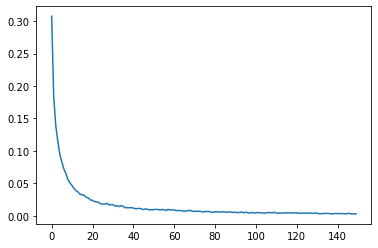

train  accuracy:  0.99995
test  accuracy:  0.9814
[[ 975    1    1    0    0    1    0    1    1    0]
 [   0 1128    3    0    0    1    2    1    0    0]
 [   8    1 1007    1    3    0    1    6    4    1]
 [   0    0    4  992    0    5    0    6    2    1]
 [   1    0    0    1  969    0    4    0    1    6]
 [   3    0    0    7    1  871    6    1    2    1]
 [   5    2    1    0    2    3  944    0    1    0]
 [   0    9    6    0    1    1    0 1002    2    7]
 [   5    1    5    1    4    2    2    2  947    5]
 [   3    4    0    6   11    0    0    4    2  979]]


In [52]:
##plot result

#plot epoch losses
plot_epoch_losses(epoch_losses)
#accuracy
print_accuracy(y_train.reshape(-1), np.argmax(train_pred, axis=1),'train')
print_accuracy(y_test.reshape(-1), np.argmax(test_pred, axis=1), 'test')
#confusion matrix
print_confusion_matrix(y_test.reshape(-1), np.argmax(test_pred, axis=1))